In [1]:
import matplotlib.pyplot as plt
import pybedtools as pbt
import glob
from tqdm import tqdm
import numpy as np
from IPython.display import clear_output
import seaborn.apionly as sns
from scipy.stats import mannwhitneyu, poisson
import json
from ipyparallel import Client
import os
from scipy.stats import fisher_exact

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.7)
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)
    return True

DVIEW = Client()[:]
DVIEW.block=True
len(DVIEW)

30

### First we need to create arrays consisting of expectation scores around center of each TRF2 peak

#### Creating peak arrays and their shuffle controls

In [34]:
def chrom_to_peaks(chrom):
    
    def bed_to_chrom_wise_interval(bed):
        chrom_wise_peaks = {x: [] for x in chroms}
        for i in bed:
            chrom_wise_peaks[i.chrom].append((i.start, i.end))
        return chrom_wise_peaks
    
    pos = numpy.load("%s/%s_positive_scores.npy" % (snipr_dir, chrom), mmap_mode='r')
    neg = numpy.load("%s/%s_negative_scores.npy" % (snipr_dir, chrom), mmap_mode='r')
    
    interval_scores = []
    chrom_wise_peaks = bed_to_chrom_wise_interval(pybedtools.BedTool(bed_file))
    for i in chrom_wise_peaks[chrom]:
        peak_mid = i[0] + (i[1] - i[0])
        interval_scores.append(pos[peak_mid-offset:peak_mid+offset] +
                               neg[peak_mid-offset:peak_mid+offset])
    interval_scores = numpy.array(interval_scores)
    a_mean = [numpy.sum(x)/len(numpy.nonzero(x)[0])
                  if len(numpy.nonzero(x)[0]) > 0 else 0 for x in interval_scores]
    a_ac_sum = sum([1 if len(numpy.where(x >= 185)[0]) > 0 else 0
                    for x in interval_scores])
    
    b_means = []
    b_ac_sums = []
    for i in range(num_iters):
        chrom_wise_peaks = bed_to_chrom_wise_interval(
            pybedtools.BedTool(bed_file).shuffle(chrom=True, g=chrom_info_file))
        shuffle_scores = []
        for i in chrom_wise_peaks[chrom]:
            peak_mid = i[0] + (i[1] - i[0])
            shuffle_scores.append(pos[peak_mid-offset:peak_mid+offset] +
                        neg[peak_mid-offset:peak_mid+offset])
        shuffle_scores = numpy.array(shuffle_scores)
        b_means.append([numpy.sum(x)/len(numpy.nonzero(x)[0])
                  if len(numpy.nonzero(x)[0]) > 0 else 0 for x in shuffle_scores])
        b_ac_sums.append(sum([1 if len(numpy.where(x >= 185)[0]) > 0 else 0
                        for x in shuffle_scores]))
    return a_mean, a_ac_sum, b_means, b_ac_sums

num_iters = 1000
chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
with DVIEW.sync_imports():
    import numpy
    import pybedtools

_ = DVIEW.push(dict(
        #bed_file=os.path.abspath('../data/TRF2/IDR_peaks.bed'),
        bed_file=os.path.abspath('../data/TRF2/all_common_peaks.bed'),
        offset=100,
        snipr_dir=os.path.abspath('../data/snipr'),
        chroms=chroms,
        chrom_info_file='/home/parashar/scratch/hg19_resource/hg19.genome',
        num_iters=num_iters
))

res = DVIEW.map_sync(chrom_to_peaks, chroms)
a_mean, a_ac_sum, b_means, b_ac_sums = ([], 0, [[] for x in range(num_iters)],
                                        [0 for x in range(num_iters)])
for i in res:
    a_mean.extend(i[0])
    a_ac_sum += i[1]
    for j in range(num_iters):
        b_means[j].extend(i[2][j])
        b_ac_sums[j] += i[3][j]
#save_dir = '../data/TRF2/idr'
save_dir = '../data/TRF2/all'
np.save('%s_peaks_scores' % save_dir, np.array(a_mean, dtype=float))
np.save('%s_peaks_above_185' % save_dir, np.array([a_ac_sum], dtype=int))
np.save('%s_shuffle_peaks_scores' % save_dir, np.array(b_means, dtype=float))
np.save('%s_shuffle_peaks_above_185' % save_dir, np.array(b_ac_sums, dtype=int))

importing numpy on engine(s)
importing pybedtools on engine(s)


### Now lets investigate whether SNIPR-Q scores in the TRF2 peak region is actually higher than expectation

In [35]:
save_dir = '../data/TRF2/all'
a_mean = np.load('%s_peaks_scores.npy' % save_dir)
a_ac_sum = np.load('%s_peaks_above_185.npy' % save_dir)
b_means = np.load('%s_shuffle_peaks_scores.npy' % save_dir)
b_ac_sums = np.load('%s_shuffle_peaks_above_185.npy' % save_dir)

In [37]:
pvals = []
for i in tqdm(range(1000)):
    pvals.append(mannwhitneyu(a_mean, b_means[i])[1])

100%|██████████| 1000/1000 [00:10<00:00, 96.10it/s]


In [46]:
np.median(a_mean), np.mean([np.median(x) for x in b_means]), max(pvals)

(34.367088607594937, 23.898017099338759, 2.6703662518331499e-41)

In [51]:
np.median(a_mean)/np.mean([np.median(x) for x in b_means])

1.4380728101724327

In [49]:
p = fisher_exact([
    [sum(a_ac_sum), a_mean.shape[0]-sum(a_ac_sum)],
    [np.mean(b_ac_sums), a_mean.shape[0]-np.mean(b_ac_sums)]
])
sum(a_ac_sum), np.mean(b_ac_sums), p

(6846, 5754.0330000000004, (1.2859258330148025, 1.2287426543569645e-31))

In [53]:
a_mean.shape, sum(a_ac_sum)/a_mean.shape[0], np.mean(b_ac_sums)/a_mean.shape[0]

((20347,), 0.3364623777461051, 0.28279515407676808)

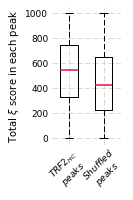

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(2, 3))

boxprops = dict(linestyle='-', linewidth=1, color='k')
whiskerprops = dict(linestyle='--', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson')

ax.boxplot([a, b[0]], sym='', widths=[0.5, 0.5],
           boxprops=boxprops, 
           medianprops=medianprops, whiskerprops=whiskerprops)
ax.set_ylabel(r'Total $\xi$ score in each peak', fontsize=10)
ax.set_xticklabels([r'$TRF2_{HC}$'+'\n'+'$peaks$', r'$Shuffled$'+'\n'+'$peaks$'],
                   rotation=45, fontsize=10)
clean_axis(ax)

plt.tight_layout()
plt.show()

In [51]:
sorted_peaks_array = peaks_array[peaks_array.sum(axis=1).argsort()[::-1]]
sorted_shuffle_array = [i[i.sum(axis=1).argsort()[::-1]] for i in shuffle_array]

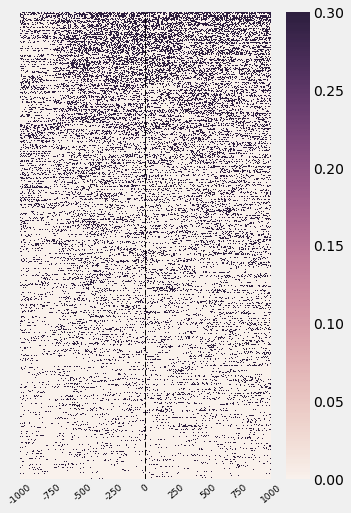

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(5, 8))

ax = sns.heatmap(sorted_peaks_array, vmax=0.3, 
          xticklabels=[], yticklabels=[], ax=ax)

ax.set_xticks([x+1000 for x in [-1000, -750, -500, -250, 0, 250, 500, 750, 1000]])
ax.set_xticklabels([-1000, -750, -500, -250, 0, 250, 500, 750, 1000], fontsize=9, rotation=40)
ax.set_yticks([])
ax.axvline(1000, ls='--', color='k', lw=1)
plt.show()

### Now we are going to look at motif based approaches and how they overlap the TRF2 binding sites

In [92]:
def make_chrom_wise_bed(bed):
    chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
    chrom_wise = {x:[] for x in chroms}
    for i in bed:
        chrom_wise[i.chrom].append(str(i).rstrip('\n'))
    for chrom in chroms:
         chrom_wise[chrom] = pbt.BedTool('\n'.join(chrom_wise[chrom]), from_string=True)
    return chrom_wise

chrom_wise_peaks = make_chrom_wise_bed(pbt.BedTool('../data/TRF2/IDR_peaks.bed'))
chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
shuffled_chrom_wise_peaks = [
    make_chrom_wise_bed(pbt.BedTool('../data/TRF2/IDR_peaks.bed').shuffle(
        chrom=True, g='/home/parashar/scratch/hg19_resource/hg19.genome')) for x in range(100)
]

In [96]:
chrom_wise_peaks

{'chr1': <BedTool(MISSING FILE: /tmp/pybedtools.y16vlecr.tmp)>,
 'chr10': <BedTool(MISSING FILE: /tmp/pybedtools.cwrrtg2h.tmp)>,
 'chr11': <BedTool(MISSING FILE: /tmp/pybedtools.pdbysmbp.tmp)>,
 'chr12': <BedTool(MISSING FILE: /tmp/pybedtools.iyf5az_w.tmp)>,
 'chr13': <BedTool(MISSING FILE: /tmp/pybedtools.bt_141qi.tmp)>,
 'chr14': <BedTool(MISSING FILE: /tmp/pybedtools.rsdw7lyr.tmp)>,
 'chr15': <BedTool(MISSING FILE: /tmp/pybedtools.z261eucz.tmp)>,
 'chr16': <BedTool(MISSING FILE: /tmp/pybedtools.5b4m5_az.tmp)>,
 'chr17': <BedTool(MISSING FILE: /tmp/pybedtools.h3ddsznz.tmp)>,
 'chr18': <BedTool(MISSING FILE: /tmp/pybedtools.4n5hzu16.tmp)>,
 'chr19': <BedTool(MISSING FILE: /tmp/pybedtools.qruxjwpx.tmp)>,
 'chr2': <BedTool(MISSING FILE: /tmp/pybedtools.wvh7q7mo.tmp)>,
 'chr20': <BedTool(MISSING FILE: /tmp/pybedtools.patn__sg.tmp)>,
 'chr21': <BedTool(MISSING FILE: /tmp/pybedtools.h1fs8k2d.tmp)>,
 'chr22': <BedTool(MISSING FILE: /tmp/pybedtools.k8b2fzfe.tmp)>,
 'chr3': <BedTool(MISSING F

In [95]:
def calc_overlap(chrom, i):
    return shuffled_chrom_wise_peaks[i][chrom].intersect(g4_bed, u=True).count()
    
with DVIEW.sync_imports():
    import pybedtools

_ = DVIEW.push(dict(
    shuffled_chrom_wise_peaks=shuffled_chrom_wise_peaks,
))
pbt.cleanup()

overlap = {}
shuffle_overlap = {}
for loop in [5, 25]:
    for bulge in [0, 5]:
        overlap['%d_%d' % (loop, bulge)] = []
        shuffle_overlap['%d_%d' % (loop, bulge)] = []
        for chrom in chroms:
            print (loop, bulge, chrom)
            g4_bed_file = '/home/parashar/scratch/quadruplexes/hg19/g3_%d_%d_%s_nov.bed' % (
                    loop, bulge, chrom)
            g4_bed = pbt.BedTool(g4_bed_file)
            overlap['%d_%d' % (loop, bulge)].append(
                chrom_wise_peaks[chrom].intersect(g4_bed, u=True).count()
            )
            _ = DVIEW.push(dict(
                g4_bed=g4_bed
            ))
            temp = DVIEW.map_sync(calc_overlap, [chrom for x in range(100)], range(100))
            shuffle_overlap['%d_%d' % (loop, bulge)].append(temp)
            clear_output()

with open('../data/TRF2/motif_overlap.json', 'w') as OUT:
    json.dump(overlap, OUT, indent=2)
with open('../data/TRF2/shuffle_motif_overlap.json', 'w') as OUT:
    json.dump(shuffle_overlap, OUT, indent=2)

importing pybedtools on engine(s)
5 0 chr1


BEDToolsError: 
Command was:

	bedtools intersect -u -b /home/parashar/scratch/quadruplexes/hg19/g3_5_0_chr1_nov.bed -a /tmp/pybedtools.y16vlecr.tmp

Error message was:
Error: Unable to open file /tmp/pybedtools.y16vlecr.tmp. Exiting.


In [68]:
overlap = json.load(open('../data/TRF2/motif_overlap.json'))
shuffle_overlap = json.load(open('../data/TRF2/shuffle_motif_overlap.json'))

In [74]:
sum(overlap['15_3'])

1211

In [84]:
shuffles = []
for i in range(100):
    shuffles.append(sum([x[i] for x in shuffle_overlap['15_3']]))

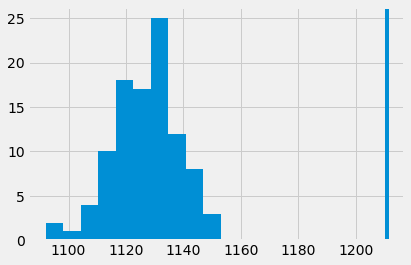

In [85]:
plt.hist(shuffles)
plt.axvline(sum(overlap['15_3']))
plt.show()

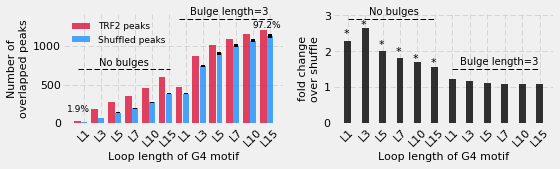

In [193]:
plt.style.use('fivethirtyeight')
def clean_axis(ax, hidegrids=False):
    ax.xaxis.set_tick_params(labelsize=11)
    ax.yaxis.set_tick_params(labelsize=11)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    if hidegrids is True:
        ax.grid(lw=0)
    else:
        ax.grid(which='major', linestyle='--', alpha=0.7)
    return True

fig, axis = plt.subplots(1, 2, figsize=(8, 2.5))

ax = axis[0]

ind1  = [0.5+x for x in range(len(overlap))]
vals1 = [sum(overlap['%d_0' % x]) for x in [1,3,5,7,10,15]] + \
        [sum(overlap['%d_3' % x]) for x in [1,3,5,7,10,15]]
ax.bar(ind1, vals1, width=0.4, label='TRF2 peaks', color='crimson', alpha=0.8)
ind2  = [0.9+x for x in range(len(overlap))]
vals2 = [np.array(shuffle_overlap['%d_0' % x]).mean(axis=1).sum() for x in [1,3,5,7,10,15]] + \
        [np.array(shuffle_overlap['%d_3' % x]).mean(axis=1).sum() for x in [1,3,5,7,10,15]]
yerr = [np.array(shuffle_overlap['%d_0' % x]).mean(axis=1).std() for x in [1,3,5,7,10,15]] + \
       [np.array(shuffle_overlap['%d_3' % x]).mean(axis=1).std() for x in [1,3,5,7,10,15]]
ax.bar(ind2, vals2, width=0.35, yerr=yerr, label='Shuffled peaks', color='dodgerblue', alpha=0.8)

ax.plot([0.5, 6], [700, 700], lw=1, color='k', ls='--')
ax.plot([6.5, 12], [1350, 1350], lw=1, color='k', ls='--')
ax.text(0.16, 0.52, 'No bulges', transform=ax.transAxes, fontsize=10)
ax.text(0.575, 0.99, 'Bulge length=3', transform=ax.transAxes, fontsize=10)

tot_peaks = sum([x.count() for x in chrom_wise_peaks.values()])
fp = (vals1[0]/tot_peaks)*100
lp = (vals1[-1]/tot_peaks)*100
ax.text(0.01, 0.1, "%.1f%%" % fp, transform=ax.transAxes, fontsize=9)
ax.text(0.86, 0.87, "%.1f%%" % lp, transform=ax.transAxes, fontsize=9)

ax.set_xticks(ind2)
ax.set_xticklabels(['L%d' % x for x in [1,3,5,7,10,15]] +
                   ['L%d' % x for x in [1,3,5,7,10,15]], rotation=45)
ax.set_xlabel('Loop length of G4 motif', fontsize=11)
ax.set_ylabel('Number of\noverlapped peaks', fontsize=11)
ax.legend(frameon=False, fontsize=9)
clean_axis(ax)


#---------------------------------------------------------------------------------------------
ax = axis[1]

shuf_vals = [np.array(shuffle_overlap['%d_0' % x]).sum(axis=0) for x in [1,3,5,7,10,15]] + \
            [np.array(shuffle_overlap['%d_3' % x]).sum(axis=0) for x in [1,3,5,7,10,15]]
pvals = [poisson.pmf(i, mu=j.mean())*tot_peaks for i,j in zip(vals1, shuf_vals)]

vals = np.array(vals1) / np.array(vals2)
ax.bar(ind1, vals, width=0.4, label='TRF2 peaks', color='k', alpha=0.8)
ax.plot([0.5,5.5], [2.9, 2.9], lw=1, color='k', ls='--')
ax.plot([6.5,11.5], [1.5, 1.5], lw=1, color='k', ls='--')
ax.text(0.16, 0.99, 'No bulges', transform=ax.transAxes, fontsize=10)
ax.text(0.575, 0.53, 'Bulge length=3', transform=ax.transAxes, fontsize=10)
ax.set_xticks(ind1)
ax.set_xticklabels(['L%d' % x for x in [1,3,5,7,10,15]] +
                   ['L%d' % x for x in [1,3,5,7,10,15]], rotation=45)
ax.set_xlabel('Loop length of G4 motif', fontsize=11)
ax.set_ylabel('Fold change\nover shuffle', fontsize=11)
for x,y in zip(range(6), [2.4, 2.65, 2.1, 1.9, 1.7, 1.6]):
    ax.text(ind1[x]-0.25, y, '*', fontsize=11)
clean_axis(ax)

plt.tight_layout()
plt.show()

In [194]:
pvals

[0.17834604786767594,
 4.1046105980750708e-26,
 5.6847394213504276e-23,
 6.1615200227555592e-22,
 3.0371559805667941e-22,
 1.5997131354579705e-21,
 0.0019676477401053853,
 0.0013255688978465814,
 0.059770259156931474,
 0.23067765667753204,
 0.4019219931821098,
 0.64662644301160932]

In [2]:
chrom_info = '/home/parashar/scratch/hg19_resource/hg19.genome'

def get_g4_bed(loop_len=7, bulge_len=0):
    base_dir = '/home/parashar/scratch/quadruplexes/hg19'
    chroms = ['chr'+str(x) for x in range(1, 23)] + ['chrX', 'chrY']
    bed = []
    for chrom in chroms:
        with open("%s/g3_%s_%s_%s_nov.bed" % (base_dir, loop_len, bulge_len, chrom)) as h:
            for l in tqdm(h, desc=chrom):
                if len(l) > 8:
                    c = l.rstrip('\n').split('\t')
                    strand = '+' if c[4][0] == 'G' else '-'
                    line = c[0:3]+[c[5], '0', strand]
                    bed.append('\t'.join(line))
    clear_output()
    return pbt.BedTool('\n'.join(bed), from_string=True).sort()

In [3]:
g4 = get_g4_bed()
g4.count()

374697

In [4]:
trf2_idr_peaks = pbt.BedTool('../data/TRF2/IDR_peaks.bed')
trf2_idr_peaks.count()

1246

In [5]:
tss_info = pbt.BedTool('/home/parashar/scratch/quadcomb/data/annotation/gencode_tss.bed')
tss_info.count()

200052

In [6]:
peaks_g4 = trf2_idr_peaks.intersect(g4, wao=True)
peaks_g4.count()

2104

In [7]:
peaks_g4 = trf2_idr_peaks.intersect(g4, u=True, wa=True)
peaks_g4.count()

347

In [8]:
peaks_g4 = g4.intersect(trf2_idr_peaks, u=True, wa=True)
peaks_g4.count()

1202

In [15]:
g4_peaks_tss = tss_info.slop(b=500, g=chrom_info).intersect(peaks_g4, wao=True)
g4_peaks_tss.count()

200257

In [16]:
transcripts = []
for i in g4_peaks_tss:
    c = str(i).rstrip('\n').split('\t')
    if c[6] != '.':
        transcripts.append(c[3])
        print (str(i).rstrip('\n'))
len(transcripts)

chr1	228752355	228753356	ENST00000363511.1	.	-	chr1	228752877	228752909	CCCCAAGAGCCCAGCCCGGCCCGGCCGTGCCC	0	-	32
chr1	228752355	228753356	ENST00000363511.1	.	-	chr1	228753157	228753179	CCCCCTCTTGCCCCACCCACCC	0	-	22
chr1	228752355	228753356	ENST00000363511.1	.	-	chr1	228753283	228753305	GGGGGGGCAAGAGGGCGTGGGG	0	+	22
chr1	228750114	228751115	ENST00000362467.1	.	-	chr1	228750636	228750668	CCCCAAGAGCCCAGCCCGGCCCGGCCGTGCCC	0	-	32
chr1	228750114	228751115	ENST00000362467.1	.	-	chr1	228750916	228750938	CCCCCTCTTGCCCCACCCACCC	0	-	22
chr1	228750114	228751115	ENST00000362467.1	.	-	chr1	228751042	228751064	GGGGGGGCAAGAGGGCGTGGGG	0	+	22
chr1	228745632	228746633	ENST00000362482.1	.	-	chr1	228746154	228746186	CCCCAAGAGCCCAGCCCGGCCCGGCCGTGCCC	0	-	32
chr1	228745632	228746633	ENST00000362482.1	.	-	chr1	228746434	228746456	CCCCCTCTTGCCCCACCCACCC	0	-	22
chr1	228745632	228746633	ENST00000362482.1	.	-	chr1	228746560	228746582	GGGGGGGCAAGAGGGCGTGGGG	0	+	22
chr1	228779173	228780174	ENST00000365387.1	.	-	chr1	

394

In [17]:
t_to_g = json.load(open(
        '/home/parashar/scratch/quadcomb/data/annotation/gencode_tid_to_gene_name.json'))

In [18]:
genes = []
for i in transcripts:
    genes.append(t_to_g[i])

In [19]:
print (len(genes), len(set(genes)))

394 72


In [21]:
print ('\n'.join(genes))

RNA5S4
RNA5S4
RNA5S4
RNA5S3
RNA5S3
RNA5S3
RNA5S1
RNA5S1
RNA5S1
RNA5S16
RNA5S16
RNA5S16
RNA5S15
RNA5S15
RNA5S15
RNA5S14
RNA5S14
RNA5S13
RNA5S13
RNA5S13
RNA5S6
RNA5S6
RNA5S6
RNA5S5
RNA5S5
RNA5S5
TINAGL1
OPN4
OPN4
OPN4
DUX4L11
DUX4L11
TENM4
TENM4
TENM4
BAD
HMGA2
HMGA2
HMGA2
HMGA2
HMGA2
HMGA2
HMGA2
RP3-488M23.3
CRACR2A
CRACR2A
CRACR2A
PLEKHG3
POLG
POLG
POLG
POLG
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ANXA2
ADGRG1
CBFA2T3
TERF2
TERF2
TERF2
TERF2
TERF2
TERF2
TERF2
TERF2
TERF2
TERF2
TERF2
TERF2
TERF2
TERF2
TERF2
SAMD14
SAMD14
SAMD14
SAMD14
SAMD14
SAMD14
SAMD14
SAMD14
SAMD14
SAMD14
SAMD14
SAMD14
SAMD14
SAMD14
SAMD14
SAMD14
SAMD14
SAMD14
SAMD14
SAMD14
SAMD14
SAMD14
SAMD14
SAMD14
SAMD14
SAMD1

In [20]:
print ('\n'.join([x for x in set(genes) if x[:3] not in ['RNA', 'MIR'] ]))

TERF2
HAAO
TSHZ2
CENPBD1P1
RP3-488M23.3
RP1-261G23.5
TMEM175
ADGRG1
TERT
ALOX12B
SARS2
SGCA
SAMD14
RAPH1
TINAGL1
POLG
PRKCE
TJAP1
CREB5
THRA
DUX4L11
GRB10
OBSL1
BAD
FAM27B
PTCHD4
PCGF3
SLCO2A1
RP11-683L23.6
CBFA2T3
AC100791.2
AP005530.1
INHA
TM4SF19-AS1
CHRM2
NTNG2
CTB-60B18.10
RP11-548K12.11
OPN4
CRACR2A
LOXL2
FAM27C
CYP2F2P
CPNE5
PLEKHG3
ARRB2
RP11-514O12.4
FAM201B
TENM4
EXOC7
SMAD7
ANXA2
CD300A
TCTEX1D2
RP11-424E7.5
HMGA2
AC016629.7
KCNH2
RP11-150O12.6
RP11-447L10.1
